In [1]:
# Predicting Furniture Sales using TimeSeries.

In [ ]:
# As in timeseries we will take order date and sales only 2 columns.

In [1]:
import warnings
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize']=14
matplotlib.rcParams['xtick.labelsize']=12
matplotlib.rcParams['ytick.labelsize']=12
matplotlib.rcParams['text.color']='k'

In [2]:
# There are several categories in the superstore sales data, we start from timeseries and forecasting for furniture sales.

In [3]:
df = pd.read_excel('C:/Users/Amit/Desktop/Data EDA/Superstore.xls')

In [4]:
furniture = df.loc[df['Category']== 'Furniture']

In [5]:
furniture['Order Date'].min, furniture['Order Date'].max()

(<bound method NDFrame._add_numeric_operations.<locals>.min of 0      2016-11-08
 1      2016-11-08
 3      2015-10-11
 5      2014-06-09
 10     2014-06-09
           ...    
 9962   2015-03-19
 9964   2016-12-05
 9980   2015-09-06
 9989   2014-01-21
 9990   2017-02-26
 Name: Order Date, Length: 2121, dtype: datetime64[ns]>,
 Timestamp('2017-12-30 00:00:00'))

In [6]:
# Therefore we have 4 years of data which is good

In [7]:
#Data pre-processing keeping only order_date and sales

furniture = furniture[['Order Date','Sales']]

In [8]:
furniture.head()

,Order Date,Sales
0,2016-11-08,261.9600
1,2016-11-08,731.9400
3,2015-10-11,957.5775
5,2014-06-09,48.8600
10,2014-06-09,1706.1840


In [9]:
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [10]:
furniture.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2121 entries, 0 to 9990
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order Date  2121 non-null   datetime64[ns]
 1   Sales       2121 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 49.7 KB


In [11]:
# order date is in date time format all good

In [12]:
# Now time series takes aggrigated data so we will make our data aggrigated.

In [13]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [14]:
furniture.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


In [15]:
# now we will push the order date to index

furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [16]:
# Now to see how my data looks like we will see the mean value of sales to check if data is stationary or not.

In [17]:
# we are using here moving avg and checking if sales column is stationary.
y = furniture['Sales'].resample('MS').mean()

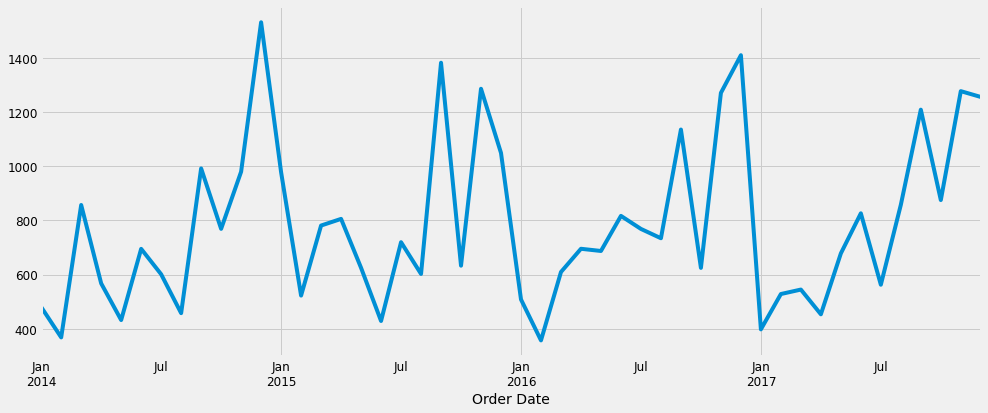

In [18]:
y.plot(figsize=(15,6))
plt.show()

In [19]:
# The timeseries has seasonality pattern, such as sales are always low at the behinning of the year
# and high at the end of the year.There is always an upward trend within any single year with a couple of low months in the mid of the year.

In [20]:
# lets decompose and see trend sesonality and noise seperately and understand it better.

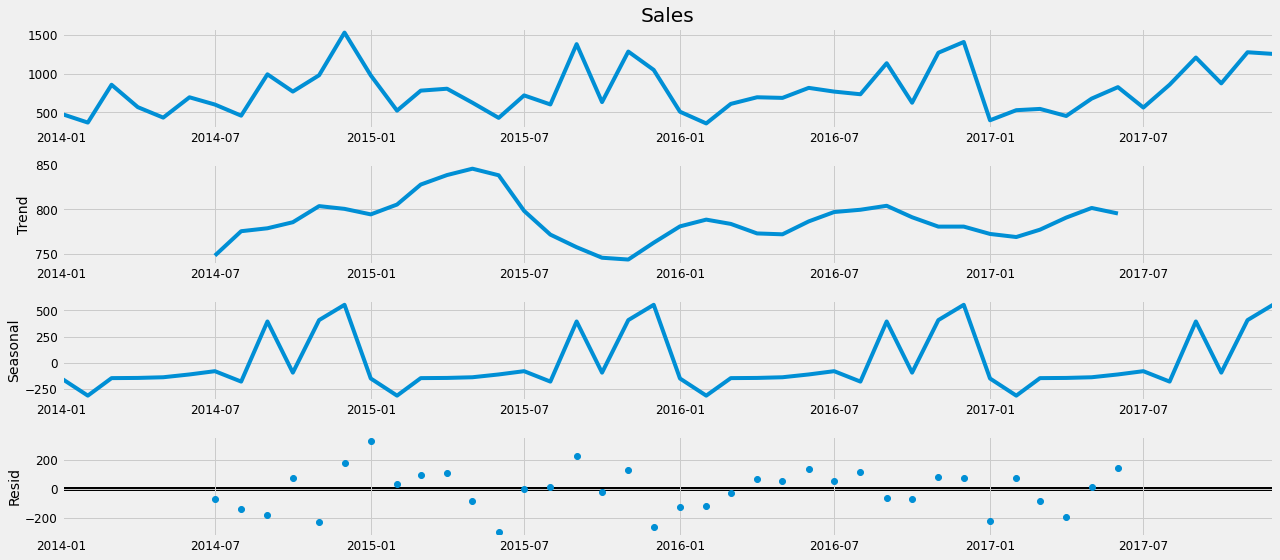

In [21]:
from pylab import rcParams
rcParams['figure.figsize']= 18,8
decomposition = sm.tsa.seasonal_decompose(y,model='additive')
fig = decomposition.plot()
plt.show()

In [22]:
# sesonality is there but is not strong so we can use only arima and check.
# if strong sesonality is there we need to go to sarima

In [23]:
# Time series with SARIMX. for thiswe need to find best pdq values which are in range 0,1,2.
# we will use grid search.

p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]
print('Examples of parameter combinations for Seasonal ARIMA....')
print('SARIMAX: {} x {}'.format(pdq[1],seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1],seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2],seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2],seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA....
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [24]:
# using grid search to find the optimal set of parameters.

In [25]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                           order=param,
                                           seasonal_order=param_seasonal,
                                           enforce_stationarity=False,
                                           enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205915
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1576.7262413607714
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.71701309202774


C:\Users\Amit\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:302.27028997937504
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.23144334183365
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1485.0473992603902


C:\Users\Amit\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:304.2488280302272
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758113


C:\Users\Amit\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2672.1798279894256
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.56074298091625
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.62613896732887


C:\Users\Amit\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Amit\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.55877541496324
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2617.7294167313403
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.9884876946868
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.87255765940466
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.894766843944


C:\Users\Amit\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1378.3751901717778
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:486.63785672412575
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:304.96712281679663
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.78896630044073


C:\Users\Amit\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1012.3977101280059
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109211
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:306.911320015139
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:649.9056176816974


C:\Users\Amit\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2092.765960533169
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:458.87055484827295
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:279.5806233332879
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:486.18329774426724
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2589.5715149048433
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:310.7574368417265
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:281.55766214612464
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:692.1645522067713


C:\Users\Amit\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1489.3824305125393
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:479.4632147852136
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:304.20776751609566
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:480.9259367935185


C:\Users\Amit\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1180.181450845156
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:304.46646750845895
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:304.58426921438866
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:665.7794442186371


C:\Users\Amit\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:506.3735408778491
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:468.3685195815138
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:293.3422193965891
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:482.5763323876798


C:\Users\Amit\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2527.322017486585
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:306.0156002125325
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:293.7513188157123
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:671.2513547541902


C:\Users\Amit\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:949.0188144758088
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:479.2003422281134
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:300.21306116190965
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:475.3403658785116
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1360.831449309516
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:300.62709013453866
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:302.326499250453
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:649.0318019835107
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1340.229565667295


C:\Users\Amit\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:460.47626876105824
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:281.38730069394035
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:469.5250354660849


C:\Users\Amit\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1885.170320179554
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:297.78754395388984
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:283.3661017479595


In [26]:
#SARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:279.5806233332879
#SARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:283.3661017479595

#The above output suggest sarimax((0, 1, 1)x(0, 1, 1, 12) yeilds the lowest AIC value of 297.78.
#Therefore we should consider this to be optimal option.

In [62]:
# fitting the values to the model

mod = sm.tsa.statespace.SARIMAX(y,
                               order=(0,1,1),
                               seasonal_order=(0,1,1,12),
                               #enforce_stationarity=False,
                               enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000   1056.616     -0.001      0.999   -2071.930    2069.930
ma.S.L12      -1.0001   1056.681     -0.001      0.999   -2072.058    2070.057
sigma2      2.686e+04      0.002   1.71e+07      0.000    2.69e+04    2.69e+04


In [41]:
# the model should be normally distributed, autocorr should be there and should pass qq test
# and mean should be close to 0 of residual.
# for finding this lets run dignostic

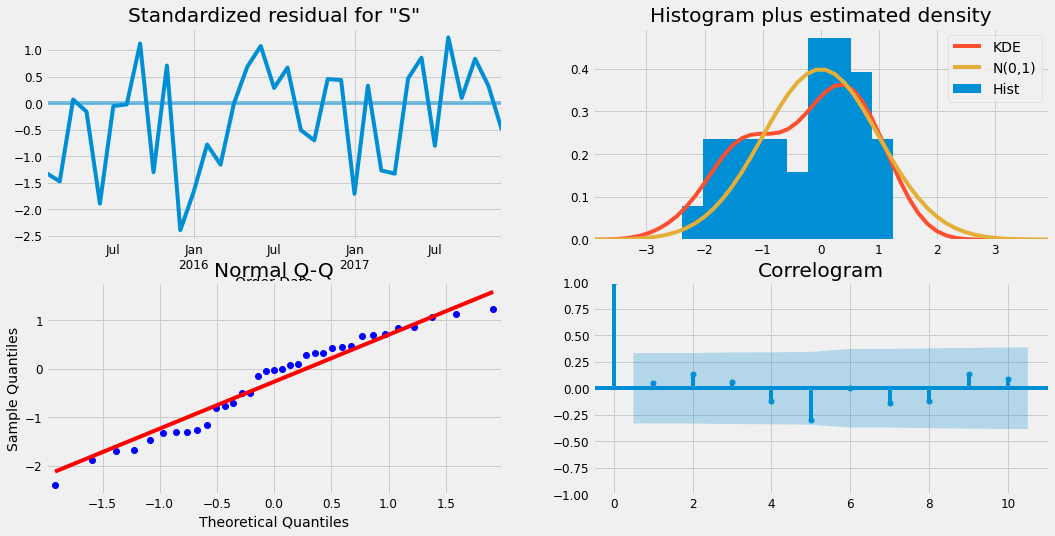

In [63]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [43]:
#Let us predict on existing dataset

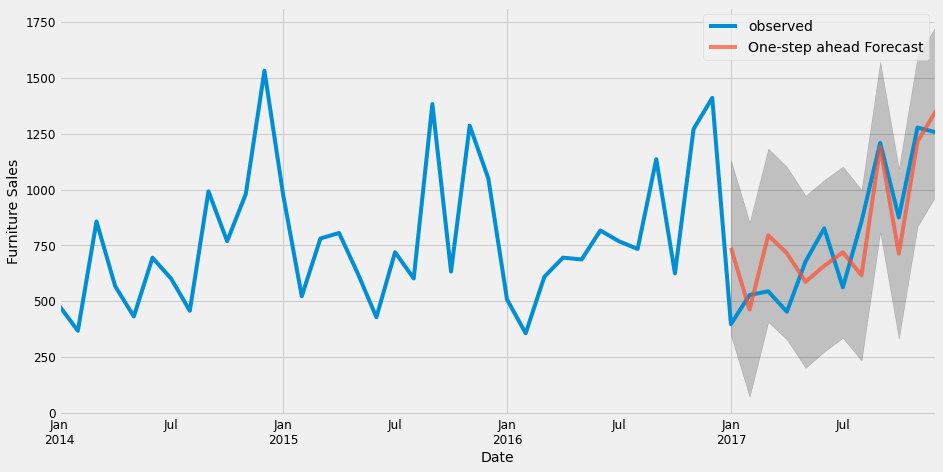

In [64]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'),dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha= .7 , figsize=(14,7))
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1],color='k',alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [56]:
# there is noise in our data so we cant accept exact prediction but
# the trend is same

In [65]:
# MSE and RMSE to check best fit
# we use mse to check best fit smaller the value the better.

y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth)**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse,2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse),2)))

The Mean Squared Error of our forecasts is 34370.12
The Root Mean Squared Error of our forecasts is 185.39


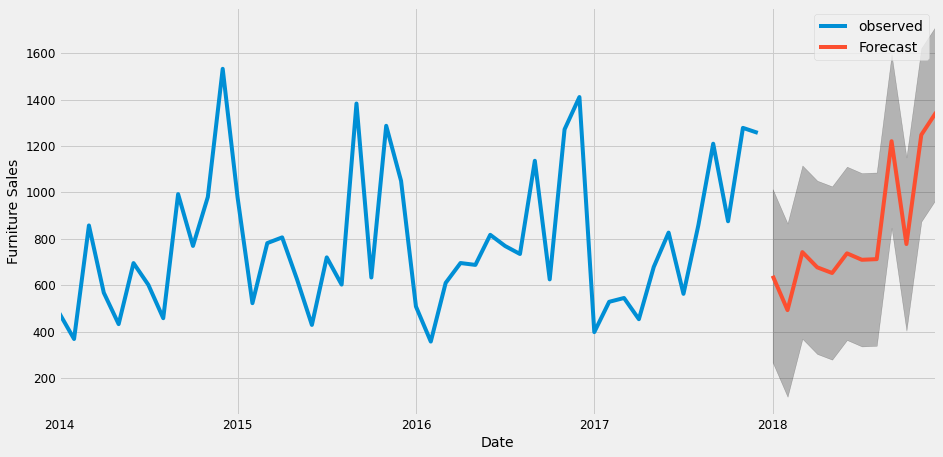

In [66]:
# Now lets Future forecast

pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed',figsize=(14,7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1],color='k',alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()